# GenAI Pulse: Mapping Sentiments and Trends around Generative AI Tools

In recent years, Generative AI tools have seen rapid adoption across industries, with tools like ChatGPT, Claude, Copilot, Gemini, Sora, and Meta AI becoming household names in both professional and personal contexts. GenAI has rapidly transformed how individuals and industries interact with technology. 

Reddit, being a vibrant community of tech enthusiasts, professionals, and early adopters, serves as a goldmine of real-world user opinions. By analyzing Reddit discussions over the past two years, this project uncovers: 
- The **popularity trends** of different GenAI tools.
- The **reception of these tools across various industries**.
- How **public sentiment** has shifted over time.
- **Forecasts of future sentiment** for ChatGPT: the key player.

This analysis combines **data visualisation**, **natural language processing**, and **machine learning techniques** to provide a comprehensive view of how generative AI is shaping online conversations and perceptions.

### Objectives
- Identify which GenAI tools are being discussed the most.
- Explore how these tools are received in IT/Tech, Education, Finance, and Healthcare industries.
- Measure the audience's sentiment for each tool over time.
- Analyze major dips and spikes in sentiment to understand the cause.
- Forecast future sentiment for ChatGPT using Facebook Prophet. 

### Dataset Details

To understand public perception and sentiment around Generative AI tools, this project uses a cleaned dataset collected from Reddit. The GenAI tools tracked in this analysis are **ChatGPT, Claude, Copilot, Gemini, Meta AI, and Sora**.  

The key columns in the dataset are: 
| Column Name | Description |
|-------------|-------------|
| 'date' | Date and time the Reddit post was created |
| 'subreddit' | The subreddit where the post was made | 
| 'title' | Title of the Reddit post |
| 'selftext' | Main content of the Reddit post |
| 'keyword' | The GenAI tool the post is related to |
| 'score' | Reddit post score (upvotes - downvotes) |
| 'comments'| Number of comments on the post |

We will import all the necessary modules and libraries first as follows. 

### Importing important Modules and Libraries

In [19]:
#Basic data handling
import pandas as pd
import numpy as np

#Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Text and NLP
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

#Time series forecasting
from prophet import Prophet

# Miscellaneous
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import re
import os

#Fetching Reddit API
import praw

### Fetching Data from Reddit API

Here is a quick look at the dataset we're working with. It includes Reddit posts related to various GenAI tools, with metadata such as date, tool name, content and engagement metrics like score and comments. 

In [8]:
# Initialize Reddit API
reddit = praw.Reddit(
    client_id='F4VMGbXT5MnCE9R23fivCw',
    client_secret='4UfsQosWALfQWdKA7wRBmp9nmjUr2A',
    user_agent='genai-pulse app'
)

# Keywords (original form)
keywords = ["ChatGPT", "Claude", "Copilot", "Sora", "Gemini", "Meta AI"]

# Normalized keyword mapping (remove spaces & lowercase for matching)
normalized_keywords = {re.sub(r"\s+", "", kw).lower(): kw for kw in keywords}

# Compiled pattern for fast matching
pattern = re.compile(r'(' + '|'.join(normalized_keywords.keys()) + r')', re.IGNORECASE)

# Target subreddits
subreddits = ["Technology", "MachineLearning", "Healthcare", "Education", "Finance", "Data","Retail",
              "Media", "Entertainment", "Legal", "ArtificalIntelligence", "OpenAI", "DataScience", 
              "Computers"]

# Start data collection
for subreddit in subreddits:
    for keyword in keywords:
        for post in reddit.subreddit(subreddit).search(keyword, limit=1000, sort="new"):
            full_text = f"{post.title} {post.selftext or ''}"
            text_no_space = re.sub(r"\s+", "", full_text).lower()

            match = pattern.search(text_no_space)
            if match:
                matched_norm = match.group().lower()
                matched_keyword = normalized_keywords.get(matched_norm, "Unknown")

                data.append({
                    "date": datetime.fromtimestamp(post.created_utc),
                    "subreddit": subreddit,
                    "title": post.title,
                    "selftext": post.selftext,
                    "keyword": matched_keyword,
                    "score": post.score,
                    "comments": post.num_comments
                })

# Create directory if it doesn't exist
os.makedirs("data/raw", exist_ok=True)
                
# Save to CSV
df = pd.DataFrame(data)
df.to_csv("data/raw/reddit_genai_posts.csv", index=False)
print(f"✅ Saved {len(df)} posts to reddit_genai_posts.csv")


✅ Saved 11516 posts to reddit_genai_posts.csv


**11516** posts have been saved to the file. Now we shall clean the dataset to remove spams and duplicates articles. 

### Data cleaning and preprocessing

In [12]:
df = pd.read_csv(r"data/raw/reddit_genai_posts.csv")

df.drop_duplicates(subset=["title", "selftext"], inplace=True)

df.dropna(subset=["title", "selftext"], inplace=True)

df["keyword"] = df["keyword"].str.lower()

# Create directory if it doesn't exist
os.makedirs("data/processed", exist_ok=True)

df.to_csv(r"data\processed\cleaned_reddit_genai_posts.csv", index = False)

print(f" Cleaned data saved. Final post count: {len(df)}")

 Cleaned data saved. Final post count: 1802


Note how **11516** articles fetched in the beginning have been reduced to **1802** after cleaning and preprocessing. Here's how the data set looks. 

In [13]:
df.head()

,date,subreddit,title,selftext,keyword,score,comments
116,2024-11-01 16:40:49,Technology,OpenAI’s search engine is now live in ChatGPT,ChatGPT is officially an AI-powered web search...,chatgpt,94,20
479,2020-07-16 06:46:45,Technology,Twitter hacking megathread,Notable twitter accounts have been compromised...,gemini,2901,1053
484,2018-06-30 13:32:50,Technology,All you need to know about Zcash,You must have heard of [Tyler and Cameron Wink...,gemini,1,0
507,2023-02-08 07:23:55,Technology,"I’m a Tech journalist at Fortune, and author o...",**Edit: That’s all we have time for today! Tha...,chatgpt,156,80
512,2025-04-21 12:31:58,MachineLearning,Has anyone successfully set up a real-time AI ...,"Hi everyone,\n\nI’ve been trying to set up a r...",chatgpt,0,3


### Trend Analysis

In this section, we aim to explore the popularity of various Generative AI tools among users on Reddit. To visualize and compare how frequently each tool is discussed, we will use both a line chart (to observe trends over time) and a pie chart (to understand overall share of attention).

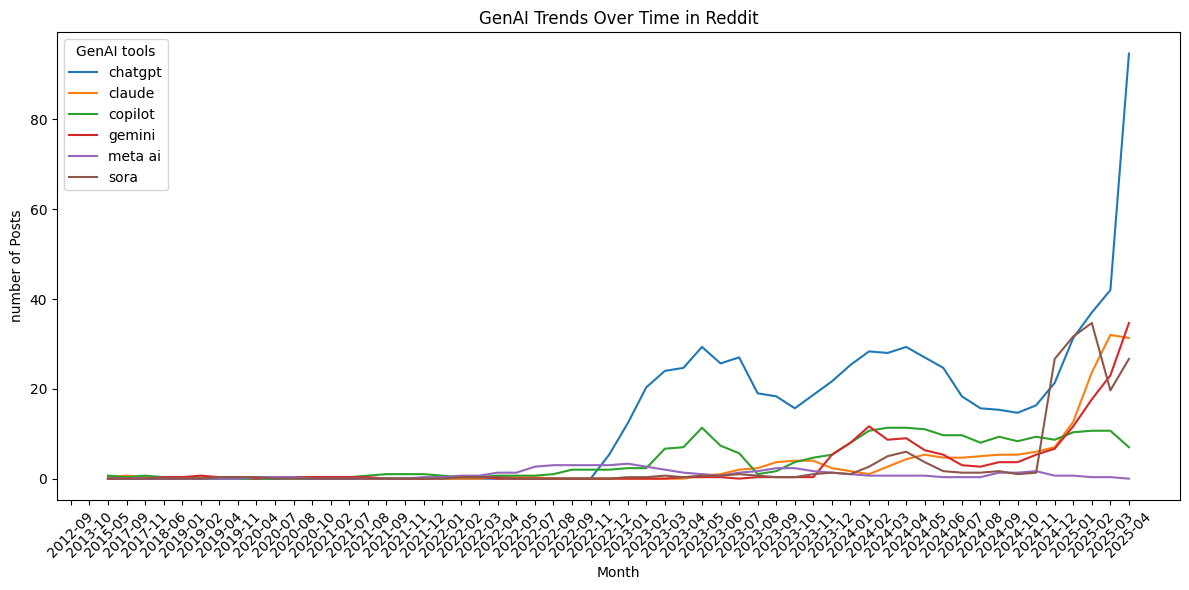

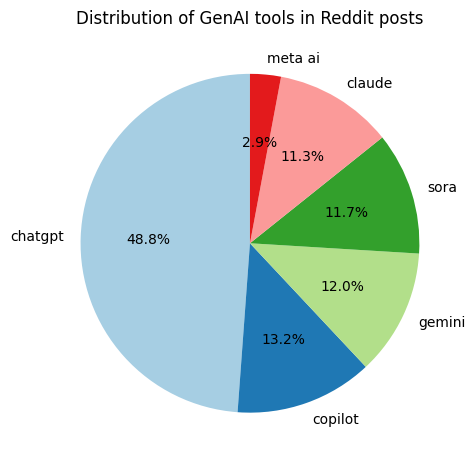

In [21]:
df = pd.read_csv(r"data\processed\cleaned_reddit_genai_posts.csv")
df['date'] = pd.to_datetime(df['date'])

trend_data = df.groupby([df['date'].dt.to_period('M'), 'keyword']).size().unstack(fill_value=0)

trend_data_smoothed = trend_data.rolling(window=3).mean()

plt.figure(figsize=(12,6))

for keyword in trend_data.columns:
    plt.plot(trend_data_smoothed.index.astype(str), trend_data_smoothed[keyword], label=keyword)

plt.title('GenAI Trends Over Time in Reddit')
plt.xlabel('Month')
plt.ylabel('number of Posts')
plt.xticks(rotation=45)
plt.legend(title='GenAI tools')
plt.tight_layout()

plt.savefig(r"plots\genai_trends.png")

plt.show()

keyword_counts = df['keyword'].value_counts()

plt.figure(figsize=(5.5,5.5))
plt.pie(keyword_counts, labels=keyword_counts.index, autopct='%1.1f%%', startangle=90,
        colors=plt.cm.Paired.colors)
plt.title('Distribution of GenAI tools in Reddit posts')

plt.savefig(r"plots\posts_distribution_pie_chart.png")
plt.show()

It is evident that ChatGPT has dominated user discussions since 2022, accounting for **48.8%** of the posts. Since 2025, its popularity has experienced a steep rise. In contrast, other GenAI tools such as Copilot, Gemini, Sora, and Claude each hold a relatively equal share of the market.

The line chart shows that ChatGPT has experienced a significant increase in posts since January 2025. Several key developments are likely driving this idea:
- **Introduction of the 'Tasks' Feature**: In January 2025, OpenAI launched a 'Tasks' feature, enhancing ChatGPT's role as a virtual assistant and increasing user engagement.
- **Release of GPT-4o**: The release of GPT-4o in January 2025 improved ChatGPT’s performance, knowledge, and ability to handle image uploads, sparking more user discussions.
- **Growth in User Base**: ChatGPT's user base grew by **33%** from December 2024 to February 2025, leading to more interactions and posts across platforms.

### Cross Industry Analysis

Now, let's dive into the cross-industry trends for different GenAI tools. To gain a comprehensive understanding, we will examine the impact and reception of these tools across a diverse range of industries, including **IT/Tech, Education, Legal, Healthcare, Finance, Retail, Media & Publishing, and Entertainment**. A heatmap has been employed to visually compare the sentiment and popularity of these tools across industries, providing a clearer picture of their performance and reception in each sector.

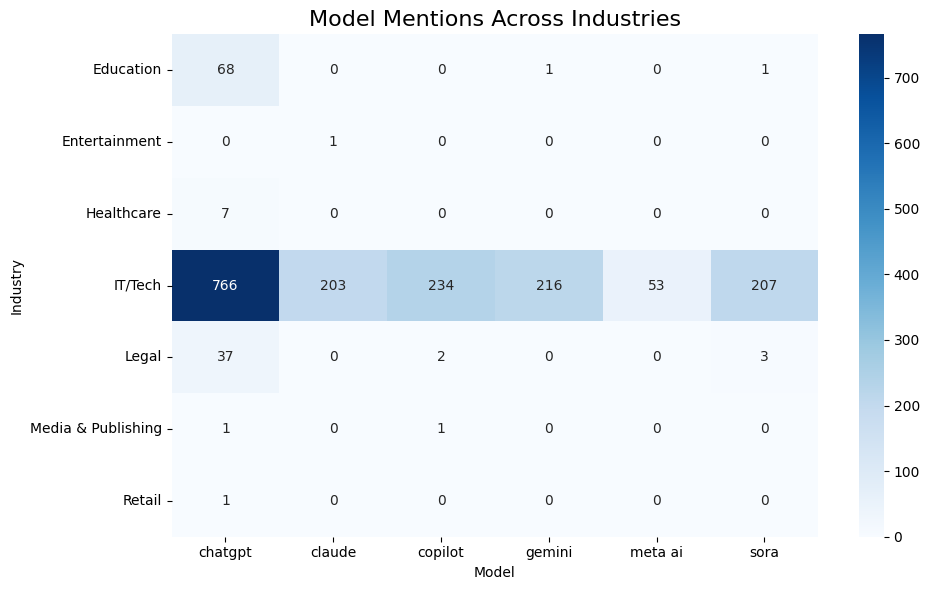

In [29]:
# Define mapping from subreddit to industry
industry_map = {
    "Technology": "IT/Tech",
    "MachineLearning": "IT/Tech",
    "Data": "IT/Tech",
    "Computers": "IT/Tech",
    "ArtificialIntelligence": "IT/Tech",
    "OpenAI": "IT/Tech",
    "DataScience": "IT/Tech",
    "Healthcare": "Healthcare",
    "Education": "Education",
    "Finance": "Finance",
    "Retail": "Retail",
    "Media": "Media & Publishing",
    "Entertainment": "Entertainment",
    "Legal": "Legal"
}

# Map subreddits to industry
if 'subreddit' in df.columns:
    df['industry'] = df['subreddit'].map(industry_map)
else:
    raise ValueError("Subreddit column not found in dataframe")

# Clean model keywords for consistency
df['keyword'] = df['keyword'].str.lower().str.strip()

# Group and count number of mentions
model_industry_counts = df.groupby(['industry', 'keyword']).size().reset_index(name='count')

# Pivot for heatmap
pivot_table = model_industry_counts.pivot(index='industry', columns='keyword', values='count').fillna(0)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap="Blues")
plt.title("Model Mentions Across Industries", fontsize=16)
plt.xlabel("Model")
plt.ylabel("Industry")
plt.tight_layout()
plt.savefig(r"plots\model_mentions_by_industry.png")
plt.show()

The heatmap reveals that the majority of mentions for GenAI models are concentrated in the **IT/Tech sector**, indicating a strong presence and interest in this industry. There are also noticeable mentions in the **Education, Healthcare, and Legal sectors**, albeit to a lesser extent, suggesting that while these tools are gaining traction, their adoption in these industries is not as widespread as in IT/Tech.

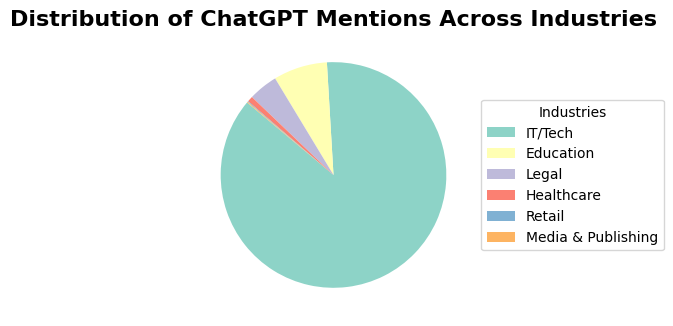

In [30]:
# Filter data for ChatGPT
chatgpt_df = df[df['keyword'].str.lower().str.contains('chatgpt')]

# Group by industry and count the posts
industry_counts = chatgpt_df['industry'].value_counts()

# Plot the pie chart
plt.figure(figsize=(5, 5))
wedges, texts = plt.pie(industry_counts, startangle=140, colors=plt.get_cmap('Set3').colors)

# Add a title
plt.title("Distribution of ChatGPT Mentions Across Industries", fontsize=16, fontweight='bold')

# Add a legend
plt.legend(wedges, industry_counts.index, title="Industries", loc="center left", 
bbox_to_anchor=(1, 0.5))

# Display the plot
plt.tight_layout()
plt.savefig(r"plots\model_mentions_chatgpt_pie.png")
plt.show()

The pie chart indicates that ChatGPT has been most frequently mentioned in the **IT/Tech, Education, and Legal sectors**. This highlights its strong presence and usage in these industries, where its applications are increasingly being recognized and adopted for various purposes, such as automation, customer service, and educational tools.

### Sentiment Analysis 

Now, let's dive deeper into the analysis by examining how different GenAI tools have been received by the audience. We will use the **SentimentIntensityAnalyzer** to assign sentiment scores to each post and classify them as 'Positive', 'Negative', or 'Neutral'.

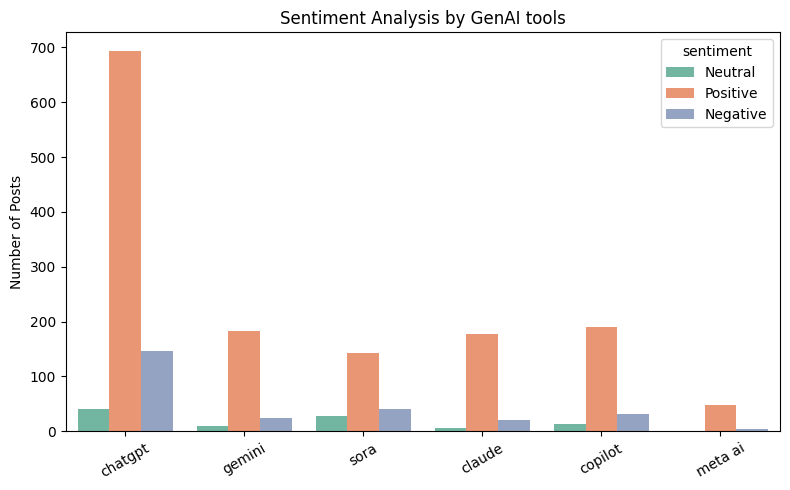

In [27]:
sia = SentimentIntensityAnalyzer()

df['full_text'] = df['title']+df['selftext'].fillna("")
df['sentiment_score'] = df['full_text'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

def classify_sentiment(score):
    if score>0.05:
        return 'Positive'
    elif score <-0.05:
        return 'Negative'
    else:
        return 'Neutral'
    
df['sentiment'] = df['sentiment_score'].apply(classify_sentiment)

df.to_csv(r"data\processed\sentiment_scored_reddit.csv", index = False)

plt.figure(figsize=(8,5))
sns.countplot(data=df, x="keyword", hue='sentiment', palette="Set2")
plt.title("Sentiment Analysis by GenAI tools")
plt.xlabel("")
plt.ylabel("Number of Posts")
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("plots/sentiment_analysis.png")
plt.show()

The stacked bar chart indicates a predominantly **positive reception** of GenAI tools among users, highlighting the growing acceptance and enthusiasm for these technologies.

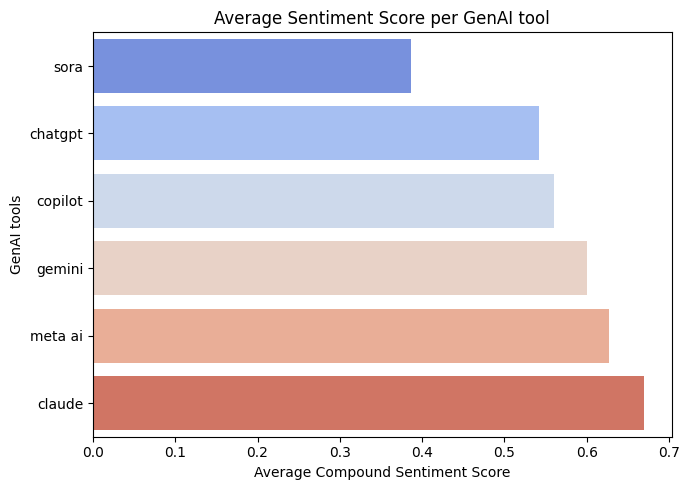

In [28]:
avg_sentiment = df.groupby('keyword')['sentiment_score'].mean().sort_values()
plt.figure(figsize=(7,5))
sns.barplot(x=avg_sentiment.values, y=avg_sentiment.index, palette="coolwarm")
plt.title("Average Sentiment Score per GenAI tool")
plt.xlabel("Average Compound Sentiment Score")
plt.ylabel("GenAI tools")
plt.tight_layout()
plt.savefig("plots/average_compound_sentiment_score.png")
plt.show()

The average compound sentiment score is instrumental in providing a comprehensive and standardized measure of overall sentiment, allowing for meaningful comparisons between different tools. 

Upon analyzing the average sentiment scores for each GenAI tool, it is clear that **Claude** has garnered the highest levels of positive sentiment, suggesting strong user satisfaction. In contrast, **ChatGPT**, while still widely discussed, shows a lower sentiment score, potentially reflecting mixed feelings or concerns. **Sora**, however, consistently receives the most negative feedback, indicating that users are less favorable towards this tool in comparison to its counterparts.

The story takes an intriguing turn as we now explore the monthly sentiment trends for each GenAI tool. By analyzing these trends, we can identify periods of significant rise and fall, offering insights into how each tool has been perceived over time. This comparison will help us understand the fluctuations in sentiment and how various factors, such as updates, media attention, or changes in user experience, may have contributed to these shifts. Additionally, it will allow us to analyze whether any tool benefited from the decline of another, shedding light on competitive dynamics in the GenAI landscape. Let’s dive into the monthly sentiment trends and see how each tool’s reception has evolved.

### Monthly Sentiment Trends

In [35]:
def plot_sentiment_trends(df, keyword, save_path):
    """
    Plots the sentiment trend for the specified models (keywords).
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the Reddit posts data.
    keywords (list): A list of model/keyword names whose sentiment trends need to be plotted.
    """
    # Extract year and month from 'date' for monthly aggregation
    df['month'] = df['date'].dt.to_period('M').astype(str)

    # Group by month and keyword to get the average sentiment score
    monthly_sentiment = df.groupby(['month', 'keyword'])['sentiment_score'].mean().reset_index()

    # Convert 'month' to datetime for plotting
    monthly_sentiment['month'] = pd.to_datetime(monthly_sentiment['month'])
    
    # Filter data for the current keyword
    keyword_data = monthly_sentiment[monthly_sentiment['keyword'].str.lower() == keyword.lower()]

    # Plot the sentiment trend for the current keyword
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=keyword_data, x='month', y='sentiment_score', label=keyword, linewidth=2)
    plt.title(f"Monthly Sentiment Trend for {keyword}", fontsize=14)
    plt.xlabel('Month')
    plt.ylabel('Average Sentiment Score')
    plt.xticks(rotation=45)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{save_path}/{keyword}_sentiment_trend.png")
    plt.show()

# Example Usage:
# Plot sentiment trends for all keywords
keywords = ["ChatGPT", "Claude", "Copilot", "Sora", "Gemini", "Meta AI"]
save_path = r"plots"


#### Monthly Sentiment Trends for ChatGPT

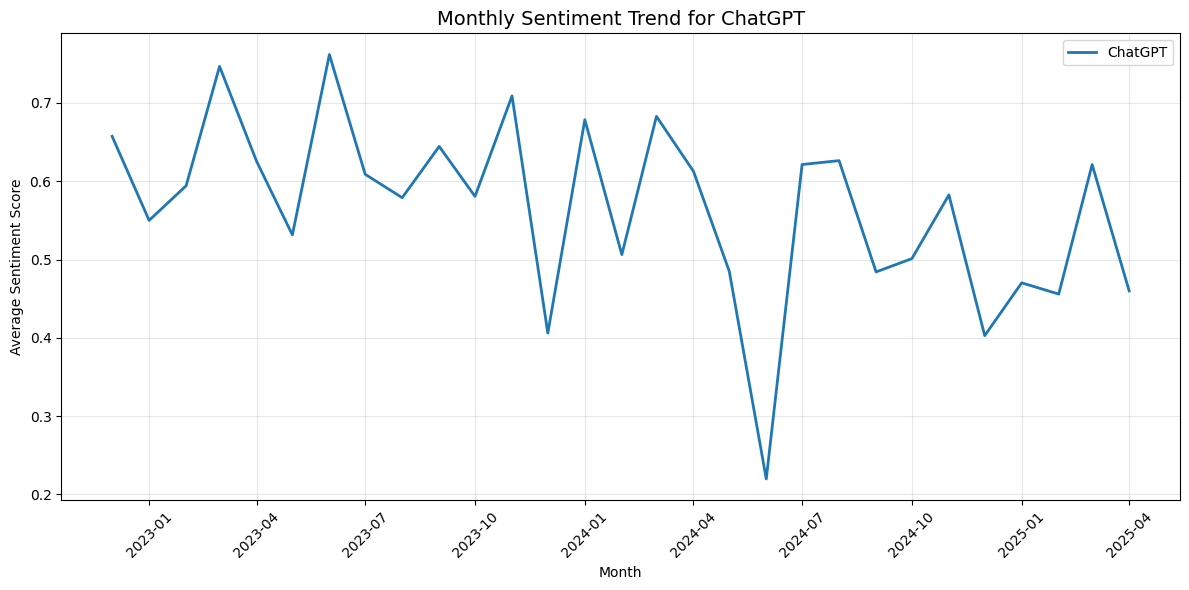

In [37]:
plot_sentiment_trends(df, "ChatGPT", save_path)

ChatGPT’s sentiment trend has largely remained positive, reflecting strong user engagement and interest. However, there have been key dips in sentiment, indicating moments of user dissatisfaction or disruption. These fluctuations seem to be driven by a mix of external challenges, rising competition, and internal performance issues. Let’s break down the major events that contributed to these shifts:

- **Legal Challenges and Public Scrutiny (Late 2023)**: In December 2023, ChatGPT faced legal scrutiny when The New York Times filed a lawsuit against OpenAI and Microsoft, alleging unauthorized use of its copyrighted articles to train the language model. This legal action raised concerns about copyright infringement and the ethical use of data, potentially impacting public perception and contributing to a temporary dip in sentiment .
- **Rising Competition from Emerging Models (Mid 2024)**: By mid-2024, new generative AI models like Claude and Gemini introduced updates that garnered user attention. As these models offered advanced capabilities and features, some users shifted their focus, leading to a decline in sentiment towards ChatGPT during this period.
- **Operational Issues and User Frustration (Late 2024)**: In December 2024, ChatGPT experienced a partial outage, resulting in significantly degraded response quality. Users reported issues such as unusable responses and degraded performance, particularly in long, context-heavy conversations. These operational challenges contributed to user frustration and a temporary drop in sentiment .

Despite these dips, ChatGPT's overall sentiment remains broadly positive, with periods of rising and falling reflecting ongoing fluctuations in user experience and perceptions.

#### Monthly Sentiment Trends for Claude

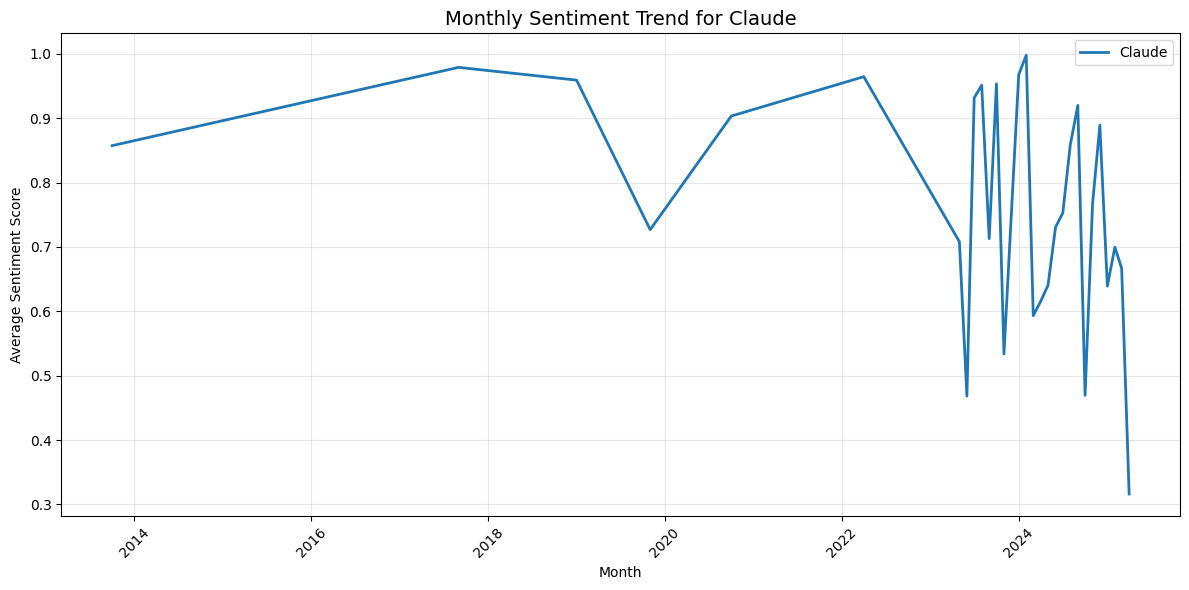

In [38]:
plot_sentiment_trends(df, "Claude", save_path)

Claude, developed by Anthropic, has experienced a dynamic journey in sentiment over time. The sentiment trajectory has been marked by significant fluctuations, with periods of improvement followed by notable dips. Here’s a breakdown of how sentiment shifted over time:

- **Initial Reception (Pre-2023)**: Claude began with a generally positive reception, appreciated for its focus on safety and ethics in AI, gaining traction in industries like healthcare and legal sectors.
- **The First Major Dip (Mid 2023)**: Around mid-2023, Claude experienced a significant drop in sentiment, driven by issues with generalization and slower response times. Users, particularly in complex sectors such as legal analysis and software engineering, found the model's performance lacking, which led to user dissatisfaction.
- **A Brief Recovery (Late 2023)**: In the latter half of 2023, the release of Claude v2.0 brought improvements to the model's performance, leading to a brief period of positive sentiment spikes as users acknowledged its enhanced capabilities.
- **The Competitive Pressure (2024)**: Despite improvements, Claude began to face increased competition from models like Gemini, which had advanced capabilities that drew users' attention away. This shift in focus led to a decline in sentiment as users migrated to these newer models.  As Claude tried to balance safety concerns with user expectations, particularly in high-stakes industries, sentiment continued to fluctuate.

In conclusion, Claude's sentiment trajectory highlights the balance between performance enhancements, ethical considerations, and the growing competition from other advanced models. These factors have contributed to its ongoing sentiment volatility.

#### Monthly Sentiment Trends for Copilot

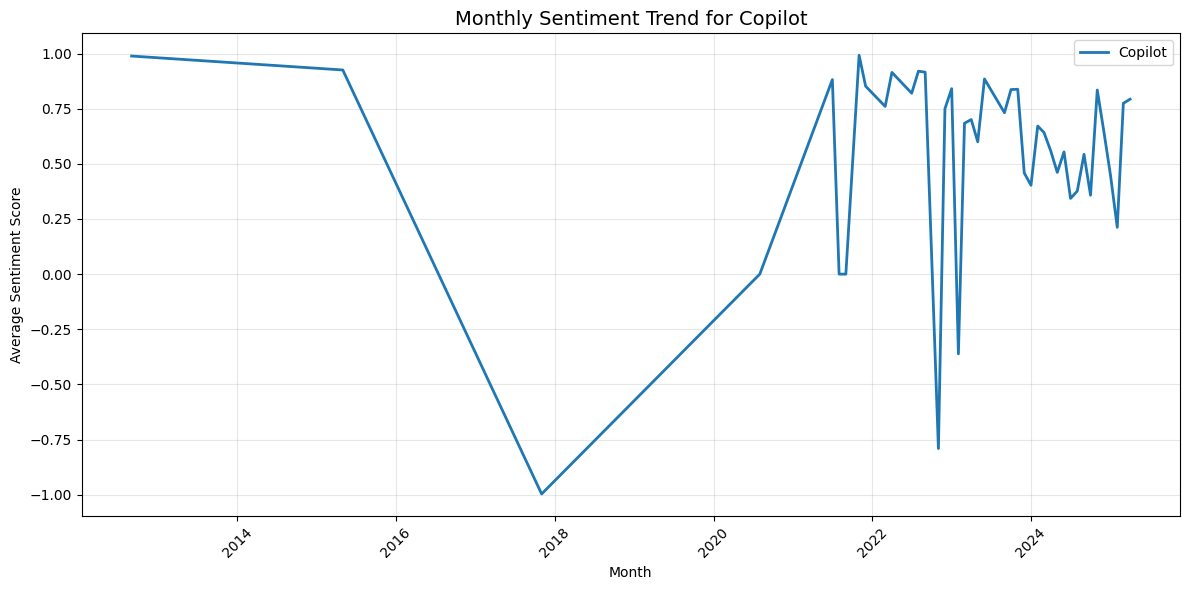

In [39]:
plot_sentiment_trends(df, "Copilot", save_path)

The sentiment trajectory of GitHub Copilot highlights a dynamic journey in user reception.
- **Initial Enthusiasm (Around 2014-2015)**: Copilot began with a highly positive sentiment, peaking near +1, likely reflecting excitement around the concept of AI-assisted coding and its early showcase.
- **Early Concerns and Decline (Post-2015)**: The sentiment began to decline as practical challenges emerged, including concerns around code correctness, security risks, plagiarism from public repositories, and a lack of a clear licensing framework.
- **Volatile Sentiment and Major Dip (2023)**: After fluctuating performance in the following years, a significant dip in 2023 likely stemmed from intensifying competition from more advanced GenAI tools, developer criticism on code reliability, and shifts in Microsoft’s pricing model or integration changes.

Despite the rollercoaster, GitHub Copilot remains a cornerstone tool for many developers—its sentiment curve reflecting a broader industry trend: from idealistic AI optimism to a more pragmatic, performance-driven mindset.

#### Monthly Sentiment Trends for Sora

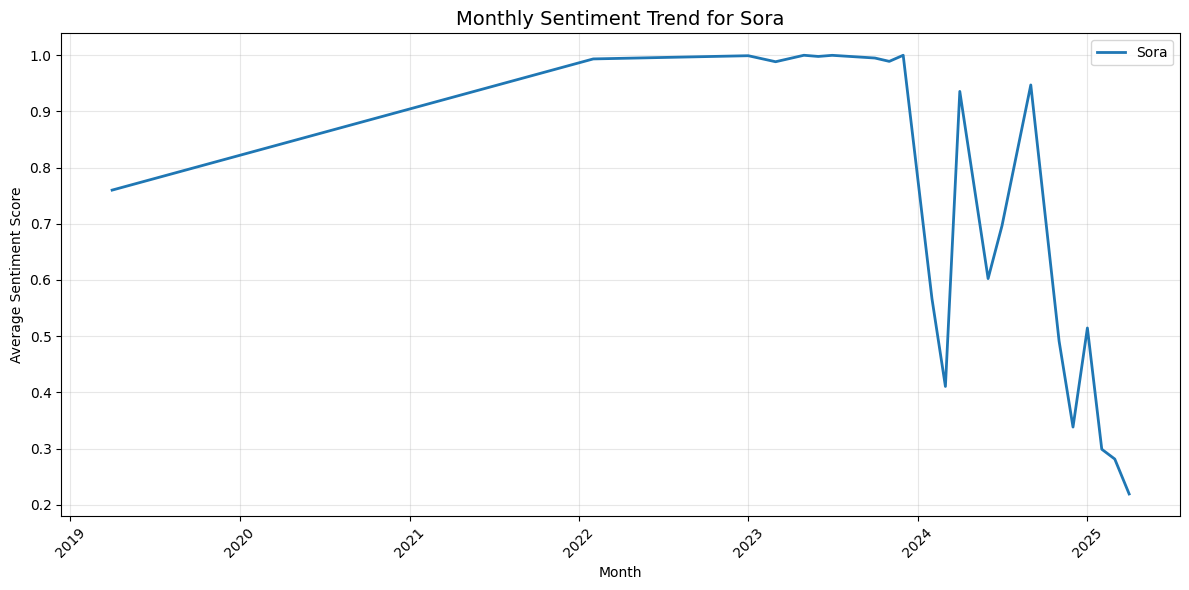

In [40]:
plot_sentiment_trends(df, "Sora", save_path)

The sentiment trajectory for Sora reveals a compelling trend that mirrors the typical hype-and-fade cycle often seen with emerging GenAI tools.
- **Initial Surge in Popularity (Throughout 2023)**: Sora experienced a sharp rise in sentiment in 2023, reaching one of the highest averages among GenAI tools. This period marked a wave of excitement around its cutting-edge ability to generate high-fidelity videos from simple text prompts. The tool was widely celebrated for its potential in creative storytelling, advertising, and virtual media production.
- **Sharp Decline and Backlash (Early 2024)**: This negative shift may be attributed to increasing concerns about ethical misuse (e.g., deepfake fears), lack of transparency in content generation, restricted access, or closed beta rollout limiting user adoption. The media coverage during this time highlighted both the power and the potential risks of video-generative AI, fueling skepticism.
- **Short Recovery Followed by Gradual Decline (Mid to Late 2024)**: After the backlash, sentiment momentarily improved—likely due to software updates, tighter safety controls, or new demos. However, this bounce was short-lived. Since the end of 2024, Sora has seen a steady decline in sentiment, possibly due to the novelty wearing off, a shift in focus toward more versatile tools like ChatGPT or Claude, and minimal real-world use cases materializing from its early promise.

Despite the downturn, Sora’s early momentum reflects the AI industry's fascination with generative media—and its sentiment journey underscores the challenge of maintaining excitement in a rapidly evolving landscape.

#### Monthly Sentiment Trends for Gemini

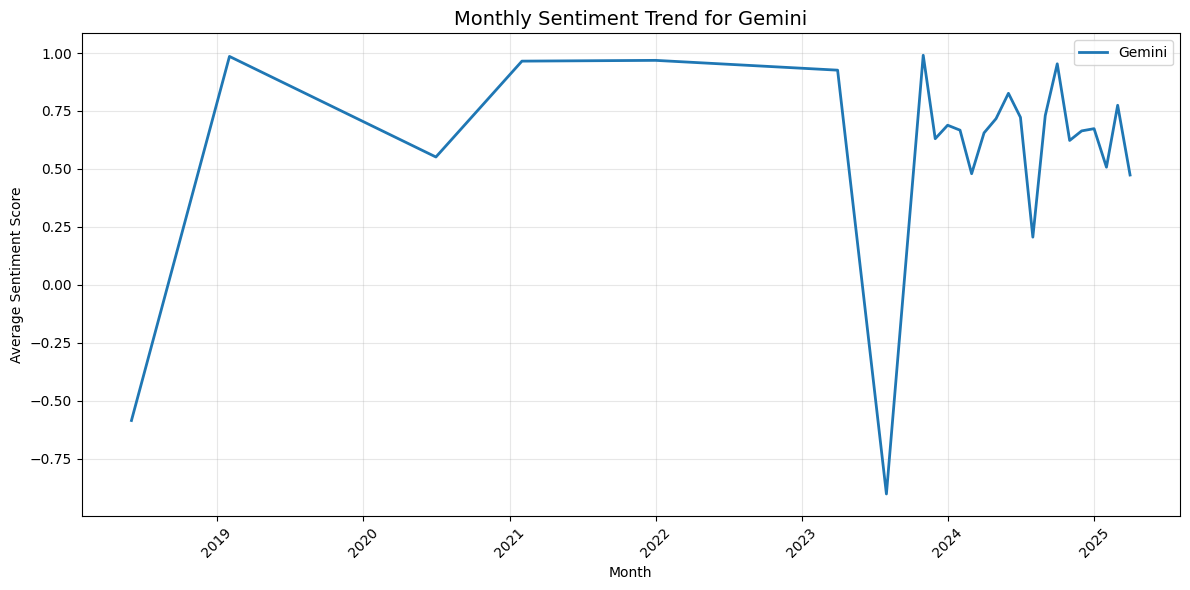

In [41]:
plot_sentiment_trends(df, "Gemini", save_path)

Gemini's sentiment journey reflects the classic arc of a high-profile GenAI tool—initial optimism, critical scrutiny, and a determined path to redemption.

- **Steady Rise and Positive Reception (2019 – Early 2023)**: From its inception, Gemini garnered a consistently positive response among users. Its integration with Google's ecosystem, combined with robust multilingual and multimodal capabilities, made it a promising contender in the GenAI race. This period reflects user trust in Google's AI innovation and expectations for seamless experiences across tools like Search, Docs, and Android.
- **Sharp Dip and Disillusionment (Mid 2023)**: Mid-2023 saw a noticeable sentiment drop. Several factors likely contributed, including mixed user feedback on early releases compared to expectations, performance issues in creative and reasoning tasks when compared with ChatGPT and Claude and concerns about privacy and data use, typical of Google products, especially from developers and enterprise users.
- **Gradual Recovery (Late 2023 Onwards)**: Gemini has since been on a recovery path. Contributing factors might include continual updates improving model performance, expanded access and integration into more Google products ,and marketing and community outreach showcasing practical applications and AI safety efforts.

Gemini’s sentiment arc illustrates the weight of expectations when backed by a tech giant—and how consistent product refinement and trust-building can help regain momentum in a competitive GenAI landscape.

#### Monthly Sentiment Trends for Meta AI

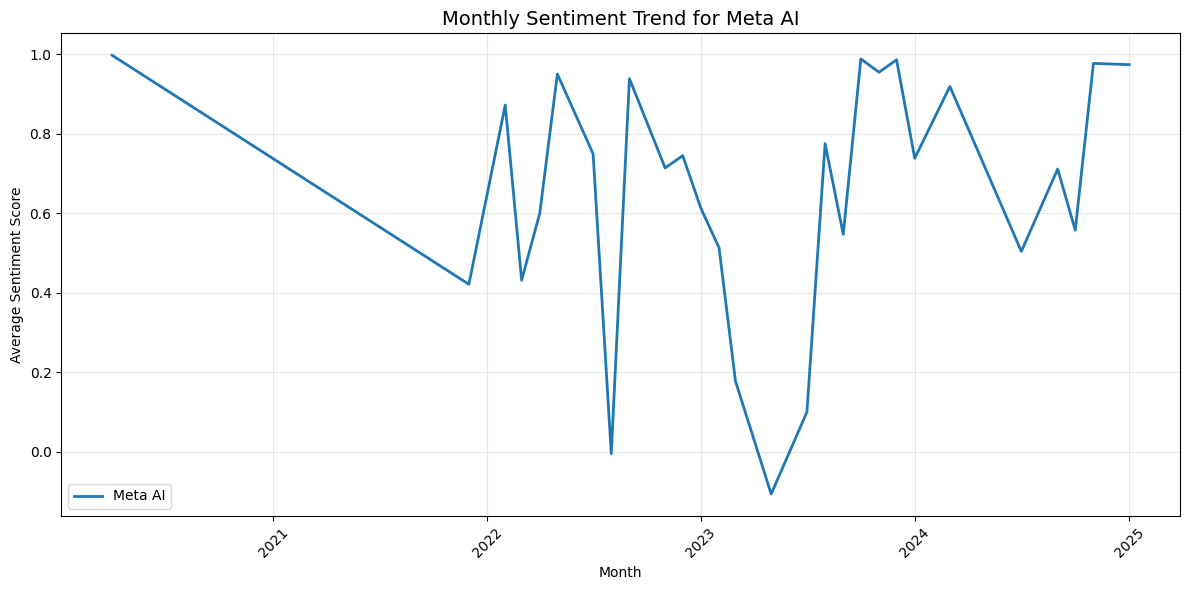

In [42]:
plot_sentiment_trends(df, "Meta AI", save_path)

Meta AI's sentiment trajectory has experienced notable fluctuations over recent years, shaped by strategic decisions, technological advancements, and market dynamics. Here's an overview of the key phases influencing its sentiment:

- **Strategic Shifts and Market Perception (2020-2022)**: Between 2020 and 2022, Meta AI's sentiment declined due to a combination of strategic and competitive factors. Meta’s aggressive pivot toward the metaverse and heavy investment in virtual reality raised concerns about diverted focus and resources, potentially sidelining its AI initiatives. At the same time, early AI models like BlenderBot faced criticism for performance issues, which hurt public confidence in Meta’s AI capabilities.
- **Challenges in AI Execution (Mid 2022)**: The launch of models like BlenderBot 3 faced backlash due to performance inconsistencies and user dissatisfaction, raising concerns about the reliability of Meta's AI offerings. These issues fueled skepticism about the company’s ability to effectively execute its AI vision, leading to a decline in both public and investor confidence.
- **Investor Skepticism and Strategic Concerns (2023)**: Despite advancements in AI, investors expressed concerns over Meta's ability to monetize AI technologies effectively. The company's focus on the metaverse continued to raise questions about the balance between AI development and other initiatives.
- **Strategic Repositioning and AI Advancements (2024-Present)**: Since 2024, Meta AI has shown signs of recovery, driven by model advancements. The introduction of models like LLaMA 3 demonstrated Meta's commitment to AI innovation, garnering positive attention. Meta's renewed focus on AI, including open-source initiatives and integration into existing platforms, has improved public perception. While challenges remain, the AI community has acknowledged Meta's efforts, leading to a gradual improvement in sentiment.

In summary, Meta AI's sentiment has been influenced by a combination of strategic decisions, product performance, and market dynamics. The company's ability to navigate these challenges and deliver on its AI promises will be crucial for sustaining positive sentiment moving forward.

The monthly sentiment trends reveal a dynamic and evolving landscape for GenAI tools, with each model experiencing its own highs and lows. While tools like ChatGPT and Claude showcased strong engagement, they also faced dips due to legal, technical, or competitive pressures. Copilot, Gemini, Sora, and Meta AI displayed varying sentiment trajectories shaped by user expectations, innovation cycles, and market positioning. Overall, the sentiment patterns highlight the fast-paced nature of the GenAI space—where constant updates, shifting perceptions, and competitive advancements drive user sentiment in real time.

#### Monthly Sentiment Forecasting for ChatGPT

Having explored the monthly sentiment trajectories for various GenAI tools, we’ve seen how public perception fluctuates in response to legal challenges, product updates, competition, and user experience. 
After analyzing the monthly sentiment trends of various GenAI tools, it’s clear that ChatGPT dominates the landscape—consistently leading in mentions, engagement, and public discourse. Its fluctuating sentiment reflects how deeply embedded it is in ongoing conversations around AI. Given its widespread popularity and relevance in today’s tech ecosystem, ChatGPT presents itself as the ideal candidate for sentiment forecasting. In this next section, we shift from trend analysis to predictive modeling to explore how sentiment around ChatGPT might evolve in the coming months.

We will perform monthly sentiment forecasting for ChatGPT posts using **Facebook Prophet** and **VADER sentiment analysis**.

15:18:27 - cmdstanpy - INFO - Chain [1] start processing
15:18:28 - cmdstanpy - INFO - Chain [1] done processing


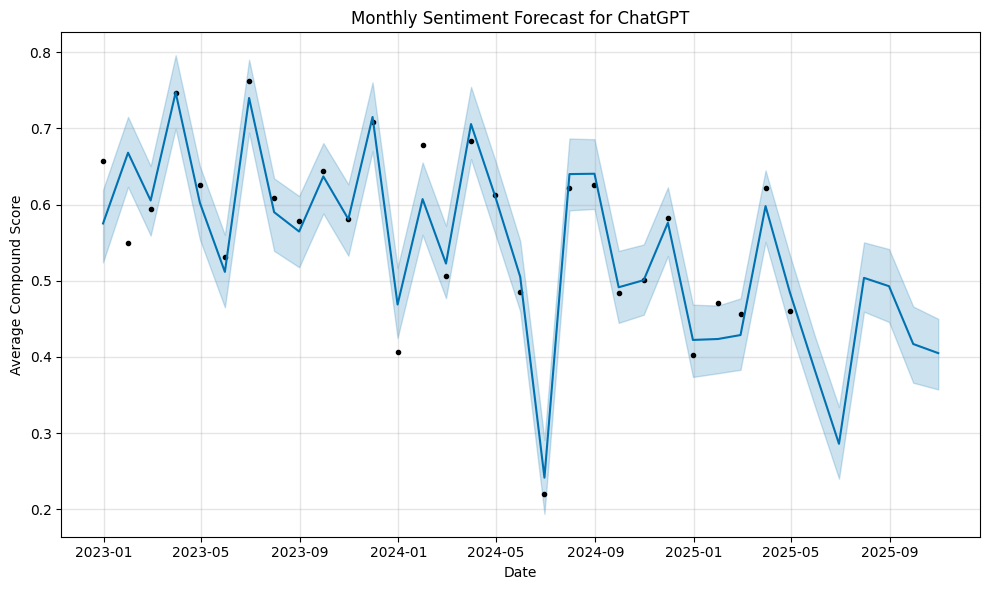

In [44]:
# 5. Filter for a specific GenAI model (e.g., ChatGPT)
df_model = df[df['keyword'].str.lower() == 'chatgpt']

# 6. Monthly average sentiment score
monthly_sentiment = df_model.resample('M', on='date')['sentiment_score'].mean().reset_index()
monthly_sentiment.columns = ['ds', 'y']  # Prophet format

# 7. Fit Prophet model
model = Prophet()
model.fit(monthly_sentiment)

# 8. Forecast future sentiment
future = model.make_future_dataframe(periods=6, freq='M')
forecast = model.predict(future)

# 9. Plot result
fig = model.plot(forecast)
plt.title("Monthly Sentiment Forecast for ChatGPT")
plt.xlabel("Date")
plt.ylabel("Average Compound Score")
plt.tight_layout()
df.to_csv(r"plots\chatgpt_forecast.png", index = False)
plt.show()

In summary, the **monthly sentiment forecasting** for ChatGPT reveals interesting insights into how user sentiment is expected to evolve. The **Prophet model**, based on historical sentiment trends, successfully captured the underlying patterns and seasonality in user reactions to ChatGPT, providing a forecast that predicts both short-term fluctuations and longer-term trends.
- The **decline in sentiment** predicted towards mid-2025 could reflect potential shifts in user perception, possibly due to rising competition, evolving expectations, or technical issues.
- However, the **sharp recovery** anticipated towards the end of 2025 suggests that ChatGPT may regain favor, possibly due to updates, new features, or an improved user experience that addresses previous concerns.

This forecast serves as a valuable tool in understanding the likely trajectory of user sentiment towards ChatGPT. By leveraging historical data and the capabilities of time series forecasting, we can anticipate trends and identify potential areas for improvement, making it an essential resource for monitoring ChatGPT's evolution in the rapidly changing landscape of GenAI tools.

### Conclusion

This report has taken a comprehensive journey through the landscape of **Generative AI** tools, focusing on understanding their **popularity, sentiment trends, and the factors driving user perception**. We started by exploring the popularity of different GenAI tools, using line charts and pie charts to reveal how tools like **ChatGPT**, **Claude**, and **Copilot** have captured user attention over time.

From there, we broadened our scope to look at how these tools are influencing various industries, offering a snapshot of their adoption and impact across **healthcare, finance, education, and IT**. This helped us uncover patterns of use and perception that reveal the true potential of these models in the real world.

We then dove deeper into the **monthly sentiment trends** for each tool, carefully analyzing the peaks and valleys that correspond to significant events, such as product updates, legal challenges, and shifts in user expectations. This analysis highlighted key moments where user sentiment soared or dipped, offering us insight into the dynamics at play.

Finally, we turned our attention to **ChatGPT**, the most discussed and widely used GenAI tool. Through **sentiment forecasting**, we explored the potential future trajectory of its user reception, predicting a temporary dip followed by a sharp recovery, based on the patterns we've observed.

By weaving together these analyses, this report not only maps the historical trends of Generative AI tools but also provides a glimpse into their evolving future. It offers a rich understanding of how user sentiment is shaped by various internal and external factors, helping businesses and developers navigate the ever-changing AI landscape with confidence.